# Advanced Modelling Process

This is demo for converting the model of tensorflow to the openvino model for better inference and optimized process

## Simple Demo

In [6]:
import tensorflow as tf
from openvino.inference_engine import IECore
import openvino.inference_engine as ie

In [1]:
import cv2 
import os
import gc
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from tensorflow import keras

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)

2.11.0


In [3]:
model = keras.models.load_model('./model/model.h5')
shape = 224

1/1 [==============================] - 0s 115ms/step
[[2.6513871e-05 9.9997354e-01]]


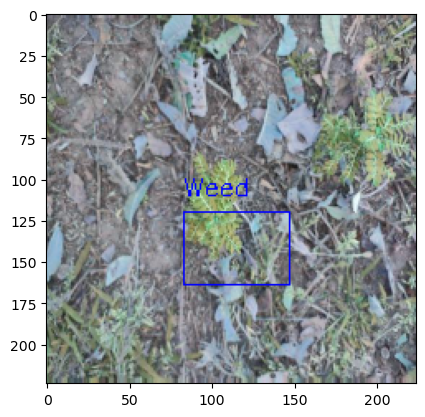

In [12]:
image = cv2.imread("./dataset/data/agri_0_151.jpeg")
image = cv2.resize(image, (shape, shape))
image_1 = np.reshape(image, (1 ,shape, shape, 3))
pred = model.predict(image_1)
print(pred[0])
startX = int(pred[1][0][0] * 224)
startY = int(pred[1][0][1] * 224)
endX =   int(pred[1][0][2] * 224)
endY =   int(pred[1][0][3] * 224)

if pred[0][0][0] > pred[0][0][1]:  # if the predicted class is crop
    label = "Crop"
    color = (0, 255, 0)  # set color to green
else:
    label = "Weed"
    color = (0, 0, 255)  # set color to red
    
cv2.rectangle(image, (startX, startY), (endX, endY), color, 1)
cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
plt.imshow(image)


## Convert the model 

In [13]:
export_path = './model/save/saved_model'

tf.saved_model.save(model, export_path)

INFO:tensorflow:Assets written to: ./model/save/saved_model\assets


INFO:tensorflow:Assets written to: ./model/save/saved_model\assets


In [14]:
import tensorflow as tf

# Load the saved model
loaded_model = tf.saved_model.load("./model/save/saved_model")

# Get the function to make predictions
infer = loaded_model.signatures["serving_default"]

# Test the model on some inputs
inputs = tf.ones([1, 224, 224, 3], dtype=tf.float32)
outputs = infer(inputs)
print(outputs)


{'Class': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.32337105, 0.676629  ]], dtype=float32)>, 'BBOX': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[0.5350202 , 0.52853   , 0.7712141 , 0.71490926]], dtype=float32)>}


In [17]:
import tensorflow as tf

# Load the Keras model
model = tf.keras.models.load_model('./model/model.h5', compile=False)

# Save the model as a saved model
tf.saved_model.save(model, './model/saved_model')

# Convert the saved model to a protobuf file
converter = tf.lite.TFLiteConverter.from_saved_model('./model/saved_model')
tflite_model = converter.convert()

# Save the tflite model to disk
open("./model/model.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: ./model/saved_model\assets


INFO:tensorflow:Assets written to: ./model/saved_model\assets


610701992

## Openvino Modelling

In [19]:
!mo -h

usage: main.py [options]

optional arguments:
  -h, --help            show this help message and exit
  --framework {mxnet,onnx,paddle,caffe,tf,kaldi}
                        Name of the framework used to train the input model.

Framework-agnostic parameters:
  --input_model INPUT_MODEL, -w INPUT_MODEL, -m INPUT_MODEL
                        {} Tensorflow*: a file with a pre-trained model
                        (binary or text .pb file after freezing). Caffe*: a
                        model proto file with model weights
  --model_name MODEL_NAME, -n MODEL_NAME
                        Model_name parameter passed to the final create_ir
                        transform. This parameter is used to name a network in
                        a generated IR and output .xml/.bin files.
  --output_dir OUTPUT_DIR, -o OUTPUT_DIR
                        Directory that stores the generated IR. By default, it
                        is the directory from where the Model Optimizer is
               

In [20]:
!mo --saved_model_dir ./model/saved_model --output_dir ./model/ir --input_shape [1,224,224,3] --data_type FP16 --framework tf


[ INFO ] The model was converted to IR v11, the latest model format that corresponds to the source DL framework input/output format. While IR v11 is backwards compatible with OpenVINO Inference Engine API v1.0, please use API v2.0 (as of 2022.1) to take advantage of the latest improvements in IR v11.
Find more information about API v2.0 and IR v11 at https://docs.openvino.ai/latest/openvino_2_0_transition_guide.html
[ SUCCESS ] Generated IR version 11 model.
[ SUCCESS ] XML file: D:\Deep Learning\Intel_oneapi\Automated-Weed-Detection\model\ir\saved_model.xml
[ SUCCESS ] BIN file: D:\Deep Learning\Intel_oneapi\Automated-Weed-Detection\model\ir\saved_model.bin


[ WARNING ]  Use of deprecated cli option --data_type detected. Option use in the following releases will be fatal. 


### Inference of the Model

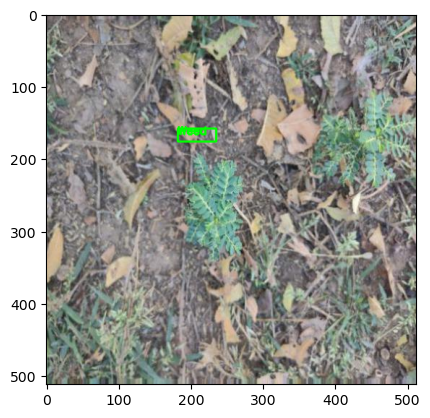

Inference time: 41.94 seconds
Class label: Weed


In [85]:
import time
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
from openvino.runtime import Core

model_xml = './model/ir/saved_model.xml'
model_bin = './model/ir/saved_model.bin'

ie = Core()
model = ie.read_model(model=model_xml, weights=model_bin)
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_key = compiled_model.input(0)
output_key = compiled_model.output(0)
class_output_key = compiled_model.output(1)
network_input_shape = input_key.shape

# The MobileNet network expects images in RGB format.
image = cv2.cvtColor(cv2.imread(filename="./dataset/data/agri_0_151.jpeg"), code=cv2.COLOR_BGR2RGB)

# Resize the image to the network input shape.
resized_image = cv2.resize(src=image, dsize=(224, 224))

# Transpose the image to the network input shape.
input_image = np.expand_dims(resized_image, 0)

# Run inference on the input image.
start_time = time.monotonic()
result = compiled_model([input_image])[output_key]
class_output =compiled_model([input_image])[class_output_key] 
end_time = time.monotonic()
inference_time = end_time - start_time

class_result = class_output
bbox_result = result

# Get class label and bbox coordinates
class_label = 'Crop' if class_result[0][0] > class_result[0][1] else 'Weed'
bbox = bbox_result[0]

# Display results on image
image_with_bbox = image.copy()
h, w, _ = image_with_bbox.shape
x_min = int(bbox[0] * w)
y_min = int(bbox[1] * h)
x_max = int(bbox[2] * w)
y_max = int(bbox[3] * h)
cv2.rectangle(image_with_bbox, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
cv2.putText(image_with_bbox, class_label, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Display image with results and print inference time
plt.imshow(image_with_bbox)
plt.show()
print(f"Inference time: {infer_time:.2f} seconds")
print(f"Class label: {class_label}")


## Sampling on the CPU 

In [86]:
num_images = 1000

start = time.perf_counter()

for _ in range(num_images):
    compiled_model([input_image])

end = time.perf_counter()
time_ir = end - start

print(
    f"IR model in OpenVINO Runtime/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)

IR model in OpenVINO Runtime/CPU: 0.0424 seconds per image, FPS: 23.61
